# Comparing Neighbor Finding: freud vs. scipy

In [1]:
import freud
import scipy
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm

In [2]:
N = 1000
L = 10
rcut = 1
box = freud.box.Box.cube(L)
seed = 0
np.random.seed(seed)
points = np.random.uniform(-L/2, L/2, (N, 3))

# Timing Functions

In [3]:
def time_statement(stmt, repeat=5, number=100, **kwargs):
    timer = timeit.Timer(stmt=stmt, globals=kwargs)
    times = timer.repeat(repeat, number)
    return np.mean(times), np.std(times)

In [4]:
def time_freud_lc(points, rcut, box):
    return time_statement("lc = freud.locality.LinkCell(box, rcut);"
                          "lc.compute(box, points, exclude_ii=False)",
                          freud=freud, points=points, rcut=rcut, box=box)

In [5]:
def time_freud_abq(points, rcut, box):
    return time_statement("aq = freud.locality.AABBQuery(box, points);"
                          "aq.queryBall(points, rcut, exclude_ii=False).toNList()",
                          freud=freud, points=points, rcut=rcut, box=box)

In [6]:
def time_scipy_ckdtree(points, rcut, box):
    shifted_points = points + np.asarray(box.L)/2
    assert box.Lx == box.Ly == box.Lz
    assert box.xy == box.xz == box.yz == 0
    return time_statement("kdtree = scipy.spatial.cKDTree(points, boxsize=L);"
                          "kdtree.query_ball_tree(kdtree, r=rcut)",
                          scipy=scipy, points=shifted_points, L=box.Lx, rcut=rcut)

In [7]:
# Test timing functions
lc_t = time_freud_lc(points, rcut, box)
print(lc_t)
abq_t = time_freud_abq(points, rcut, box)
print(abq_t)
kd_t = time_scipy_ckdtree(points, rcut, box)
print(kd_t)

(0.1479472137999999, 0.003933511862936051)
(0.06497382780000009, 0.0017601634117022922)
(0.4725816828000001, 0.001330934850760525)


# Perform Measurements

In [8]:
def measure_runtime_scaling_N(Ns, rcut, L):
    box = freud.box.Box.cube(L)
    result_times = []
    for N in tqdm(Ns):
        points = np.random.uniform(-L/2, L/2, (N, 3))
        tmp = (time_scipy_ckdtree(points, rcut, box), time_freud_abq(points, rcut, box), time_freud_lc(points, rcut, box))
        result_times.append(tmp)
    return np.asarray(result_times)

In [9]:
def plot_result_times(result_times, Ns, rcut, L):
    plt.figure(figsize=(6, 4), dpi=200)
    plt.errorbar(Ns, result_times[:, 0, 0], result_times[:, 0, 1], label="scipy v{} cKDTree".format(scipy.__version__))
    plt.errorbar(Ns, result_times[:, 1, 0], result_times[:, 1, 1], label="freud v{} AABBQuery".format(freud.__version__))
    plt.errorbar(Ns, result_times[:, 2, 0], result_times[:, 2, 1], label="freud v{} LinkCell".format(freud.__version__))
    plt.title(r'Neighbor finding for $r_{{cut}}$ = {}, $L$ = {}'.format(rcut, L))
    plt.xlabel(r'Number of points $N$')
    plt.ylabel(r'Runtime for 100 iterations (s)')
    # plt.yscale('log')
    #plt.xscale('log')
    plt.legend()
    plt.savefig('figures/comparison_rcut_{}.pdf'.format(rcut))
    plt.show()

In [10]:
# Use geometrically-spaced values of N, rounded to one significant figure
Ns = list(sorted(set(map(
    lambda x: int(round(x, -int(np.floor(np.log10(np.abs(x)))))),
    np.exp(np.linspace(np.log(50), np.log(10000), 20))))))

100%|██████████| 17/17 [02:37<00:00, 20.56s/it]


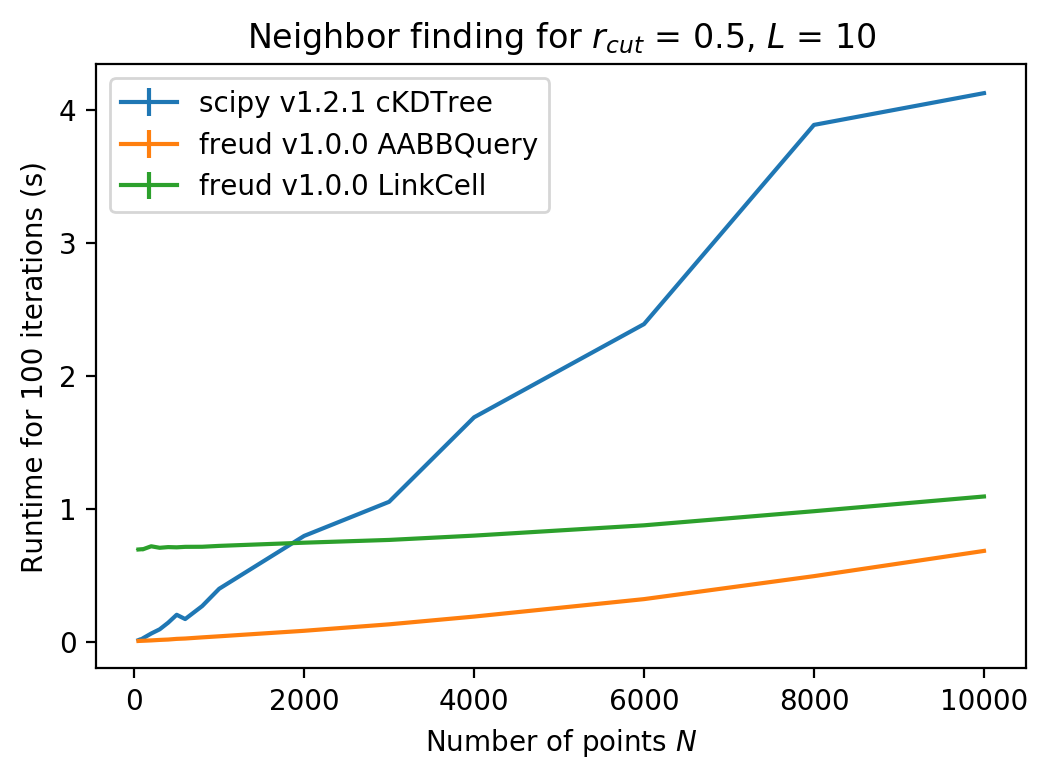

In [11]:
L = 10
rcut = 0.5
result_times = measure_runtime_scaling_N(Ns, rcut, L)
plot_result_times(result_times, Ns, rcut, L)

100%|██████████| 17/17 [03:48<00:00, 45.92s/it]


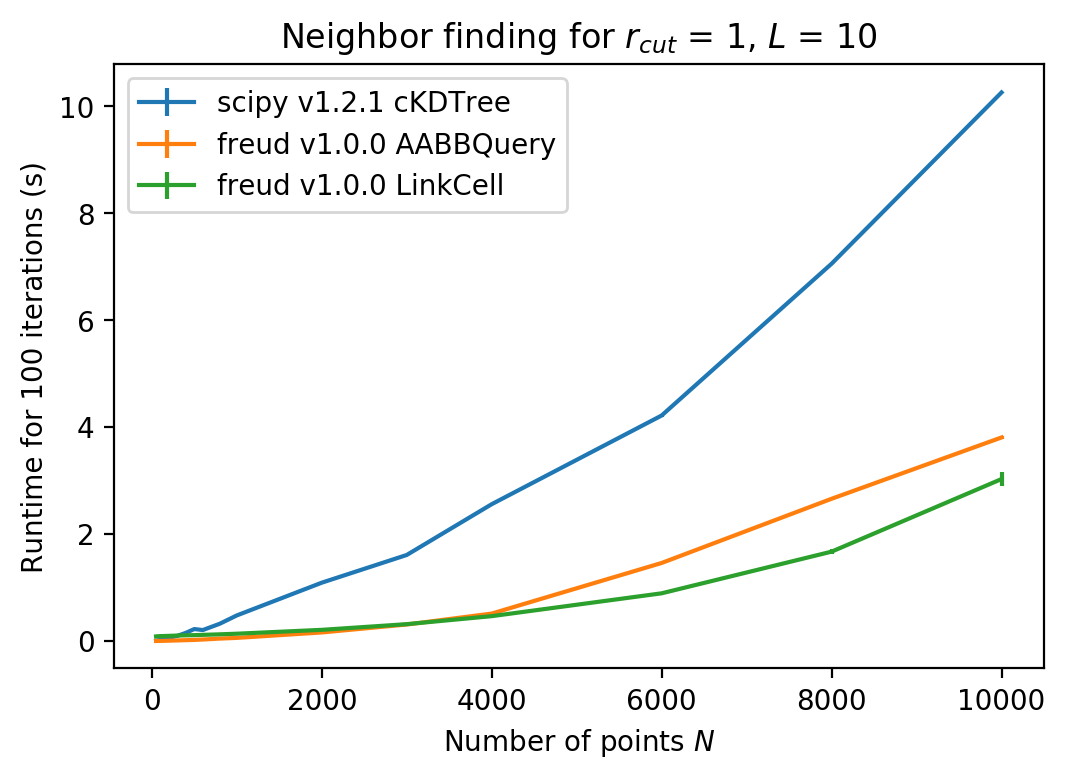

In [12]:
L = 10
rcut = 1
result_times = measure_runtime_scaling_N(Ns, rcut, L)
plot_result_times(result_times, Ns, rcut, L)

100%|██████████| 17/17 [21:17<00:00, 279.01s/it]


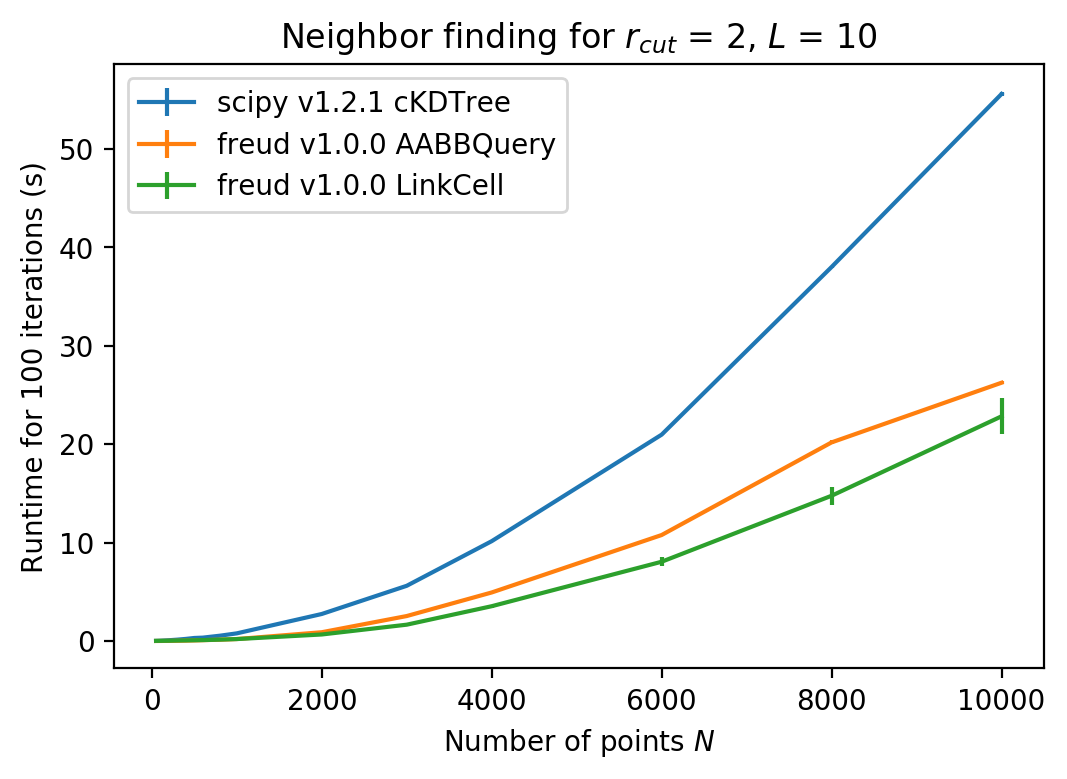

In [13]:
L = 10
rcut = 2
result_times = measure_runtime_scaling_N(Ns, rcut, L)
plot_result_times(result_times, Ns, rcut, L)